<a href="https://colab.research.google.com/github/aidanvu1992/build_week_2/blob/master/Heart_disease.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

INTRODUCTION

Objective: Predict 10 year risk of coronary heart disease in random person

In [5]:
! pip install shap
!pip install category_encoders==2.*
!pip install pandas-profiling==2.*
!pip install kaggle

     |████████████████████████████████| 266kB 2.8MB/s 
  Created wheel for shap: filename=shap-0.34.0-cp36-cp36m-linux_x86_64.whl size=383177 sha256=2768b50331bc496cda85132fcca7c6bd08542b16b821c4fc6fc7df3f4d869f05
  Stored in directory: /root/.cache/pip/wheels/28/7e/28/57bc9fcb77579b0df6561298648249370648c0b91dfe42c8ec
Successfully built shap
     |████████████████████████████████| 102kB 2.5MB/s 
     |████████████████████████████████| 153kB 2.8MB/s 
     |████████████████████████████████| 614kB 48.9MB/s 
     |████████████████████████████████| 235kB 46.9MB/s 
     |████████████████████████████████| 307kB 50.9MB/s 
     |████████████████████████████████| 51kB 7.0MB/s 
     |████████████████████████████████| 215kB 64.3MB/s 
     |████████████████████████████████| 61kB 9.9MB/s 
     |████████████████████████████████| 737kB 62.4MB/s 
  Created wheel for pandas-profiling: filename=pandas_profiling-2.4.0-py2.py3-none-any.whl size=195587 sha256=4e6c4bc0917758d8802d50abacdc896f4ba8d3d7c736a62

In [6]:
!pip install pydotplus
!pip install graphviz

In [3]:
!pip install xgboost

Import necessary functions and libraries

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.model_selection import validation_curve
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.feature_selection import f_regression, SelectKBest
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, accuracy_score, r2_score
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from sklearn.utils.multiclass import unique_labels
from sklearn.model_selection import train_test_split
from ipywidgets import interact, fixed
from xgboost import XGBRegressor, XGBClassifier
from pdpbox import pdp
from pdpbox.pdp import pdp_isolate, pdp_plot, pdp_interact, pdp_interact_plot
import eli5
from eli5.sklearn import PermutationImportance
import category_encoders as ce
import shap

LOAD DATA

In [9]:
from google.colab import files
uploaded = files.upload()

Saving framingham (1).csv to framingham (1).csv


In [10]:
df = pd.read_csv('framingham (1).csv')
df.head()

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,4.0,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,2.0,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1.0,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,3.0,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,3.0,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0


EXPLORE AND CLEAN DATA

In [0]:
# Change male to gender column. 1 is male, 0 is female
df = df.rename(columns={'male':'gender'})

In [12]:
df.dtypes

gender               int64
age                  int64
education          float64
currentSmoker        int64
cigsPerDay         float64
BPMeds             float64
prevalentStroke      int64
prevalentHyp         int64
diabetes             int64
totChol            float64
sysBP              float64
diaBP              float64
BMI                float64
heartRate          float64
glucose            float64
TenYearCHD           int64
dtype: object

In [13]:
df.nunique()

gender                2
age                  39
education             4
currentSmoker         2
cigsPerDay           33
BPMeds                2
prevalentStroke       2
prevalentHyp          2
diabetes              2
totChol             248
sysBP               234
diaBP               146
BMI                1363
heartRate            73
glucose             143
TenYearCHD            2
dtype: int64

In [14]:
df['age'].value_counts()

40    191
46    182
42    180
41    174
48    173
39    169
44    166
45    162
43    159
52    149
51    146
55    145
38    144
47    141
50    140
53    139
54    132
49    132
57    123
56    123
59    119
58    117
60    111
61    110
63    110
62     99
64     93
37     92
36     84
65     57
67     45
35     42
66     38
68     18
34     18
69      7
33      5
70      2
32      1
Name: age, dtype: int64

In [15]:
df.isnull().sum()

gender               0
age                  0
education          105
currentSmoker        0
cigsPerDay          29
BPMeds              53
prevalentStroke      0
prevalentHyp         0
diabetes             0
totChol             50
sysBP                0
diaBP                0
BMI                 19
heartRate            1
glucose            388
TenYearCHD           0
dtype: int64

In [16]:
df.describe()

,gender,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
count,4238.000000,4238.000000,4133.000000,4238.000000,4209.000000,4185.000000,4238.000000,4238.000000,4238.000000,4188.000000,4238.000000,4238.000000,4219.000000,4237.000000,3850.000000,4238.000000
mean,0.429212,49.584946,1.978950,0.494101,9.003089,0.029630,0.005899,0.310524,0.025720,236.721585,132.352407,82.893464,25.802008,75.878924,81.966753,0.151958
std,0.495022,8.572160,1.019791,0.500024,11.920094,0.169584,0.076587,0.462763,0.158316,44.590334,22.038097,11.910850,4.080111,12.026596,23.959998,0.359023
min,0.000000,32.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,107.000000,83.500000,48.000000,15.540000,44.000000,40.000000,0.000000
25%,0.000000,42.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,206.000000,117.000000,75.000000,23.070000,68.000000,71.000000,0.000000
50%,0.000000,49.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,234.000000,128.000000,82.000000,25.400000,75.000000,78.000000,0.000000
75%,1.000000,56.000000,3.000000,1.000000,20.000000,0.000000,0.000000,1.000000,0.000000,263.000000,144.000000,89.875000,28.040000,83.000000,87.000000,0.000000
max,1.000000,70.000000,4.000000,1.000000,70.000000,1.000000,1.000000,1.000000,1.000000,696.000000,295.000000,142.500000,56.800000,143.000000,394.000000,1.000000


In [0]:
# Getting data for people with age greater than 33 and less than 69
condition = (df['age'] > 33) & (df['age'] < 69)

In [0]:
df = df[condition]

In [19]:
df['age'].value_counts()

40    191
46    182
42    180
41    174
48    173
39    169
44    166
45    162
43    159
52    149
51    146
55    145
38    144
47    141
50    140
53    139
54    132
49    132
57    123
56    123
59    119
58    117
60    111
61    110
63    110
62     99
64     93
37     92
36     84
65     57
67     45
35     42
66     38
68     18
34     18
Name: age, dtype: int64

SET UP TRAIN, TEST, VAL DATASETS

In [0]:
# Train, val split
train, val = train_test_split(df, train_size=0.80, test_size=0.20, 
                              stratify=df['TenYearCHD'], random_state=42)

In [0]:
# Train, test split
train, test = train_test_split(df, train_size=0.80, test_size=0.20, 
                              stratify=df['TenYearCHD'], random_state=42)

In [22]:
train.head()

,gender,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
577,0,37,2.0,1,30.0,0.0,0,0,0,NaN,115.0,79.0,28.41,85.0,NaN,0
2965,1,39,1.0,1,20.0,0.0,0,0,0,202.0,108.0,74.0,25.51,64.0,104.0,0
4107,0,43,2.0,1,30.0,0.0,0,0,0,199.0,104.0,79.0,20.12,72.0,64.0,0
2611,1,49,1.0,1,20.0,0.0,0,0,0,288.0,128.0,89.0,35.96,73.0,75.0,0
3795,0,48,1.0,0,0.0,0.0,0,1,0,224.0,152.5,90.0,29.80,67.0,85.0,0


In [0]:
# Target
target = 'TenYearCHD'

# Get a dataframe with all train columns except the target
train_features = train.drop(columns=[target])

# Get a list of the numeric features
feats = train_features.select_dtypes(include='number').columns.tolist()

In [0]:
# Arrange data into X features matrix and y target vector
X_train = train[feats]
y_train = train[target]
X_val = val[feats]
y_val = val[target]
X_test = test[feats]
y_test = test[target]

In [25]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((3378, 15), (3378,), (845, 15), (845,), (845, 15), (845,))

CREATING MODEL USING RANDOM FOREST CLASSIFIER

In [26]:
random_forest = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='median'),
    RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
)

param = {
    'simpleimputer__strategy': ['median'],
    'randomforestclassifier__n_estimators': [150, 200, 220, 230],
    'randomforestclassifier__bootstrap': [True],
    'randomforestclassifier__max_depth': [10,20,25, 30],
    'randomforestclassifier__min_samples_leaf': [1,3],
    'randomforestclassifier__min_samples_split': [4,5,6,7,8]
}

search = RandomizedSearchCV(
    random_forest, 
    param_distributions=param, 
    random_state=44,
    n_iter=5, 
    cv=4, 
    scoring= 'accuracy', 
    verbose=10, 
    return_train_score=True, 
    n_jobs=-1
)


# Fit on train, score on val
search.fit(X_train, y_train)
print('Best hyperparameters', search.best_params_)
print('Cross-validation Accuracy', -search.best_score_)

Fitting 4 folds for each of 5 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   16.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   16.5s finished


Best hyperparameters {'simpleimputer__strategy': 'median', 'randomforestclassifier__n_estimators': 230, 'randomforestclassifier__min_samples_split': 4, 'randomforestclassifier__min_samples_leaf': 1, 'randomforestclassifier__max_depth': 10, 'randomforestclassifier__bootstrap': True}
Cross-validation Accuracy -0.8507985361339353


In [27]:
random_forest.fit(X_train, y_train)
print('Validation Accuracy:', random_forest.score(X_val, y_val), 
      '\nTest Accuracy:', random_forest.score(X_test, y_test))

Validation Accuracy: 0.8414201183431953 
Test Accuracy: 0.8414201183431953


In [0]:
CHECKING ROC SCORE FOR DATA LEAKAGE

In [28]:
# ROC score
y_pred_proba = search.predict_proba(X_val)[:, 1]
print(roc_auc_score(y_val, y_pred_proba))
search.best_params_

0.6837517433751743


{'randomforestclassifier__bootstrap': True,
 'randomforestclassifier__max_depth': 10,
 'randomforestclassifier__min_samples_leaf': 1,
 'randomforestclassifier__min_samples_split': 4,
 'randomforestclassifier__n_estimators': 230,
 'simpleimputer__strategy': 'median'}

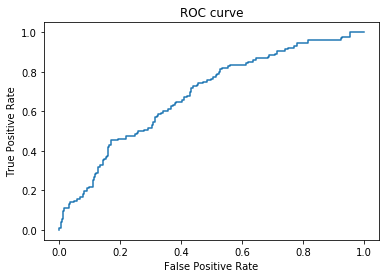

In [29]:
# Plot ROC curve
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_val==1, y_pred_proba)
plt.plot(fpr, tpr)
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate');

In [0]:
# Permutation Importances

import eli5
from eli5.sklearn import PermutationImportance

# Using eli5 to find permutation importances

# transforming data for permuter
transformers = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='median')
)

X_train_transformed = transformers.fit_transform(X_train)
X_val_transformed = transformers.fit_transform(X_val)

# setting model
model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X_train_transformed, y_train)

# setting permuter to permutation importance
permuter = PermutationImportance(
    model, 
    scoring='accuracy',
    n_iter=3,
    random_state=42
)

# fitting the data
permuter.fit(X_val_transformed, y_val)
feature_names = X_val.columns.tolist()

PI = eli5.show_weights(
    permuter,
    top=None,
    feature_names = feature_names
)

In [40]:
PI

Weight,Feature
0.0000 ± 0.0033,gender
0 ± 0.0000,prevalentStroke
-0.0008 ± 0.0059,diaBP
-0.0012 ± 0.0000,BPMeds
-0.0012 ± 0.0019,cigsPerDay
-0.0016 ± 0.0030,heartRate
-0.0024 ± 0.0000,BMI
-0.0024 ± 0.0019,glucose
-0.0028 ± 0.0011,currentSmoker
-0.0028 ± 0.0011,education


VISUALIZATION

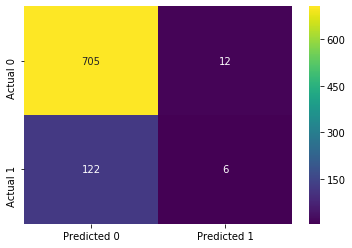

In [41]:
def plot_confusion_matrix(y_true, y_pred):
    labels = unique_labels(y_true)
    columns = [f'Predicted {label}' for label in labels]
    index = [f'Actual {label}' for label in labels]
    table = pd.DataFrame(confusion_matrix(y_true, y_pred), 
                         columns=columns, index=index)
    return sns.heatmap(table, annot=True, fmt='d', cmap='viridis')

y_pred = random_forest.predict(X_test)
plot_confusion_matrix(y_val, y_pred);

In [47]:
xgboost = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='median'),
    XGBClassifier(n_estimators=100, random_state=42, n_jobs=-1)
)

xgboost.fit(X_train, y_train)
print('Validation Accuracy:', xgboost.score(X_val, y_val), 
      '\nTest Accuracy:', xgboost.score(X_test, y_test))

Validation Accuracy: 0.842603550295858 
Test Accuracy: 0.842603550295858


In [48]:
target = 'TenYearCHD'
features = train.columns.drop([target])

X = train[features]
y = train[target]

# Use Ordinal Encoder, outside of a pipeline
encoder = ce.OrdinalEncoder()
X_encoded = encoder.fit_transform(X)

model = XGBClassifier(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X_encoded, y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [0]:
# Create isolated feature
feature='gender'

isolated = pdp_isolate(
    model = model,
    dataset = X_encoded,
    model_features = X_encoded.columns,
    feature = feature
)

(<Figure size 1080x684 with 2 Axes>,
 {'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f321aef3eb8>,
  'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f321b13ac18>})

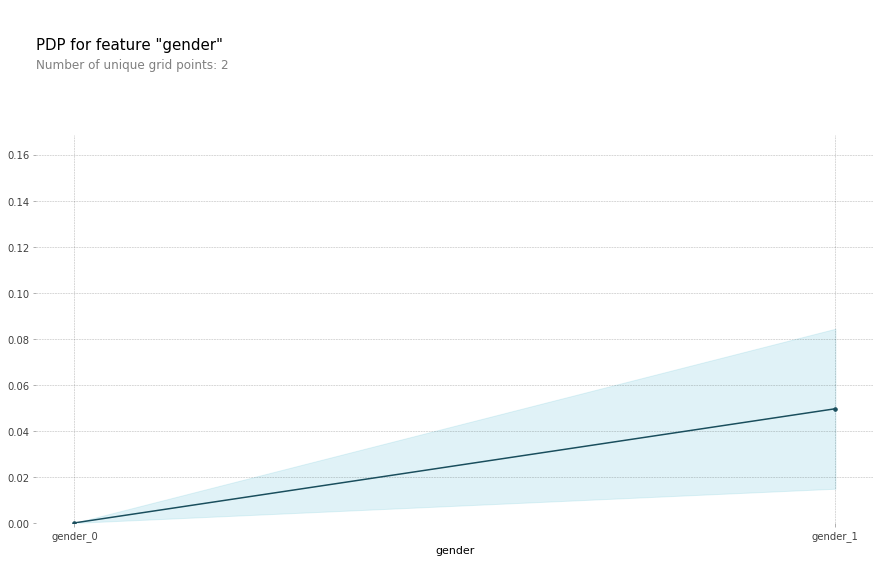

In [50]:
# PDP 1 feature isolation
pdp_plot(isolated, feature_name=feature)

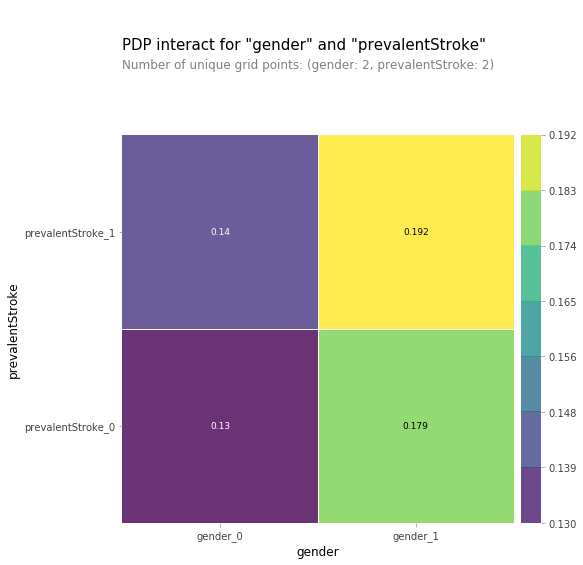

In [51]:
#PDP 2 features interaction
features = ['gender', 'prevalentStroke']

interaction = pdp_interact(
    model=model, 
    dataset=X_encoded, 
    model_features=X_encoded.columns, 
    features=features
)

pdp_interact_plot(interaction, plot_type='grid', feature_names=features);